In [7]:
import sys
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import typing as ty
# from sklearn.utils import shuffle
import logging
import keras as k
import typing as ty
import numpy.typing as npt
import numpy.polynomial.polynomial as npp
import scipy.stats.distributions as spsd

In [13]:
EXPERIMENT_NAME = "lo_mlp_updated_CustomLoss"

CEDAR_PRE_PATH = "/home/aaa327/projects/ctb-stelzer/aaa327"
LOCAL_PRE_PATH = "/Users/atakanazakli/SFU_Thesis_Work"
ML2_PRE_PATH = "/fast_scratch_4/aaa327"

PRE_PATH = LOCAL_PRE_PATH

PLOT_SAVE_DIR = f"{PRE_PATH}/GitHub_MSc_Repo/plots_model_prediction/lo_plots/{EXPERIMENT_NAME}"
MODEL_SAVE_DIRECTORY = f"{PRE_PATH}/GitHub_MSc_Repo/saved_models/lo_saved_models/{EXPERIMENT_NAME}"
CHECKPOINT_PATH = f"{PRE_PATH}/GitHub_MSc_Repo/saved_models/lo_saved_models/{EXPERIMENT_NAME}"


FEATURES_PATH = f"{PRE_PATH}/datasets/all_data/lo_root_files/new_features/train_features.npy"
LABELS_PATH = f"{PRE_PATH}/datasets/all_data/lo_root_files/new_features/train_labels.npy"

# Where the test data are located
SEARCH_DIR = f"{PRE_PATH}/datasets/all_data/lo_root_files/new_features/npy_files"


if not os.path.exists(MODEL_SAVE_DIRECTORY):
    os.makedirs(MODEL_SAVE_DIRECTORY)
if CHECKPOINT_PATH != None and not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)
if PLOT_SAVE_DIR != None and not os.path.exists(PLOT_SAVE_DIR):
    os.makedirs(PLOT_SAVE_DIR)

VALIDATION_SPLIT = 0.2
EARLY_STOPPING = True
PATIENCE = 50
MIN_DELTA = 0.0
REDUCE_LR_ON_PLATEAU = False
CHECKPOINT_PERIOD = 50
EPOCHS = 15

# Function to find all files in a directory with a specific name
def find_files(search_dir=".", file_name_to_be_searched=None):
    search_pattern = os.path.join(search_dir, "**", file_name_to_be_searched)
    return glob.glob(search_pattern, recursive=True)

# Get cHW value from file name
def get_cHW(path):
    return float(path.split("/")[-1].split("_")[-1][:-4])

# cHW_value : weight
cHW_dic = {0.0: 0.00112598,
 -0.1: 0.001147274,
 -1.0: 0.0014416,
 -2.0: 0.0020291,
 -5.0: 0.00608081,
 -10.0: 0.0254231,
 0.1: 0.001107908,
 1.0: 0.001025449,
 2.0: 0.001091368,
 5.0: 0.00187389,
 10.0: 0.00371504,}

reverse_dic = {v: k for k, v in cHW_dic.items()}

# SMEFT_weight/SM_weight : cHW_value
diff_corss_section_ratio_dic = {1.0: 0.0,
1.01891153: -0.1,
1.28030693: -1.0,
1.80207464: -2.0,
5.40046004: -5.0,
22.5786426: -10.0,
0.98394998: 0.1,
0.91071689: 1.0,
0.96926056: 2.0,
1.66423027: 5.0,
3.29938365: 10.0}

In [9]:

# Custom loss function for the Quadratic Classifier architecture
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, weight_ratio_to_cHW_dict, reduction=tf.keras.losses.Reduction.AUTO, name='custom_loss'):
        """
        Initialize the custom loss function
        Args:
            weight_ratio_to_cHW_dict: Dictionary mapping float keys to float values
            reduction: Keras reduction method
            name: Name of the loss function
        """
        super().__init__(reduction=reduction, name=name)
        # Store the original dictionary for serialization
        self.weight_ratio_to_cHW_dict = {float(k): float(v) for k, v in weight_ratio_to_cHW_dict.items()}
        # Convert dictionary to two parallel lists: keys and values
        sorted_items = sorted(self.weight_ratio_to_cHW_dict.items())
        self.keys = tf.constant([k for k, v in sorted_items], dtype=tf.float32)
        self.values = tf.constant([v for k, v in sorted_items], dtype=tf.float32)
        # SM weight hardcoded for now, CHANGE THIS
        self.sm_weight = 0.00112598

    def call(self, y_true, y_pred):
        """
        Calculate the loss
        Args:
            y_true: Diffrential cross section ratios
            y_pred: Predicted values for the differential cross section ratios
        Returns:
            Calculated loss value
        """
        # Ensure y_true is shape (batch_size, 1)
        y_true = tf.reshape(y_true, [-1, 1])
        
        # Calculate differences with explicit broadcasting
        keys_expanded = tf.reshape(self.keys, [1, -1])
        y_true_tiled = tf.tile(y_true, [1, tf.shape(self.keys)[0]])
        
        # Calculate differences
        diffs = tf.abs(y_true_tiled - keys_expanded)
        
        # Get the corresponding dictionary values
        closest_idx = tf.argmin(diffs, axis=1)
        cHW_value = tf.gather(self.values, closest_idx)
        cHW_value = tf.reshape(cHW_value, [-1, 1])
        
        # Split prediction into two parts, model output1 and model output2
        output1, output2 = tf.split(y_pred, 2, axis=1)
        
        y_calculated = tf.square(1 + cHW_value * output1) + tf.square(cHW_value * output2)
        
        multiply_by_weight = (1 + y_true)*self.sm_weight
        # I didn't take the log of this, be careful!
        return tf.reduce_mean(multiply_by_weight*tf.square(1_000_000/(1+y_calculated) - 1_000_000/(1+y_true)))

    def get_config(self):
        """Enables loss serialization"""
        base_config = super().get_config()
        return {**base_config, 'weight_ratio_to_cHW_dict': self.weight_ratio_to_cHW_dict}

    @classmethod
    def from_config(cls, config):
        """Enables loss deserialization"""
        weight_ratio_to_cHW_dict = config.pop('weight_ratio_to_cHW_dict')
        return cls(weight_ratio_to_cHW_dict=weight_ratio_to_cHW_dict, **config)

In [10]:
# You can define your own model here
class CustomModel(tf.keras.Model):
    def __init__(self, data):
        super().__init__()
        self.normalization = tf.keras.layers.Normalization()
        self.normalization.adapt(data)
        
        self.network = tf.keras.Sequential([
            self.normalization,
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('ELU'),
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('ELU'),
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('ELU'),
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('ELU'),
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('ELU'),
            tf.keras.layers.Dense(2)
        ])
        
    def call(self, inputs):
        return self.network(inputs)


In [11]:
class EpochModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):
    """A class to checkpoint models after a certain number of epochs instead of batches"""

    def __init__(self,
                 filepath: str,
                 frequency: int = 1,
                 monitor: str = "val_loss",
                 verbose: int = 0,
                 save_best_only: bool = False,
                 save_weights_only: bool = False,
                 mode: str = "auto",
                 options=None,
                 **kwargs):
        super(EpochModelCheckpoint, self).__init__(filepath, monitor, verbose, save_best_only, save_weights_only,
                                                   mode, "epoch", options)
        self.epochs_since_last_save = 0
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        # pylint: disable=protected-access
        if self.epochs_since_last_save % self.frequency == 0:
            self._save_model(epoch=epoch, batch=None, logs=logs)

    def on_train_batch_end(self, batch, logs=None):
        pass

# Training Example

In [14]:
features = np.load(FEATURES_PATH)
labels = np.load(LABELS_PATH)
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model = CustomModel(features)
model.compile(optimizer=optimizer, loss=CustomLoss(diff_corss_section_ratio_dic))
history = model.fit(features, labels, batch_size=1024, shuffle=True, epochs=EPOCHS, verbose=2,callbacks=[*((tf.keras.callbacks.EarlyStopping("val_loss" if VALIDATION_SPLIT > 0.0 else "loss", 
                                                              patience=PATIENCE, 
                                                              min_delta=MIN_DELTA, 
                                                              restore_best_weights=True),) if EARLY_STOPPING else tuple()), 
                                    *((EpochModelCheckpoint(filepath=CHECKPOINT_PATH, 
                                                            monitor="val_loss" if VALIDATION_SPLIT > 0.0 else "loss", 
                                                            mode="min", 
                                                            save_best_only=True, 
                                                            save_weights_only=False, 
                                                            frequency=CHECKPOINT_PERIOD),) 
                                      if CHECKPOINT_PATH is not None else tuple())], 
                         validation_split=VALIDATION_SPLIT)

Features shape: (4000122, 46)
Labels shape: (4000122,)
Epoch 1/15
3126/3126 - 14s - loss: 72119808.0000 - val_loss: 20280296.0000 - 14s/epoch - 5ms/step
Epoch 2/15
3126/3126 - 14s - loss: 9124917.0000 - val_loss: 3484791.2500 - 14s/epoch - 4ms/step
Epoch 3/15
3126/3126 - 14s - loss: 2015970.3750 - val_loss: 1140960.5000 - 14s/epoch - 4ms/step
Epoch 4/15
3126/3126 - 14s - loss: 765013.0000 - val_loss: 487371.8750 - 14s/epoch - 5ms/step
Epoch 5/15
3126/3126 - 14s - loss: 473316.3438 - val_loss: 459050.3750 - 14s/epoch - 4ms/step
Epoch 6/15
3126/3126 - 14s - loss: 394348.8438 - val_loss: 361879.3125 - 14s/epoch - 5ms/step
Epoch 7/15
3126/3126 - 14s - loss: 369331.5000 - val_loss: 388068.7188 - 14s/epoch - 5ms/step
Epoch 8/15
3126/3126 - 14s - loss: 357452.1250 - val_loss: 331674.1562 - 14s/epoch - 5ms/step
Epoch 9/15
3126/3126 - 14s - loss: 351210.7188 - val_loss: 330824.9688 - 14s/epoch - 5ms/step
Epoch 10/15
3126/3126 - 14s - loss: 345663.3438 - val_loss: 333328.5625 - 14s/epoch - 5ms/s

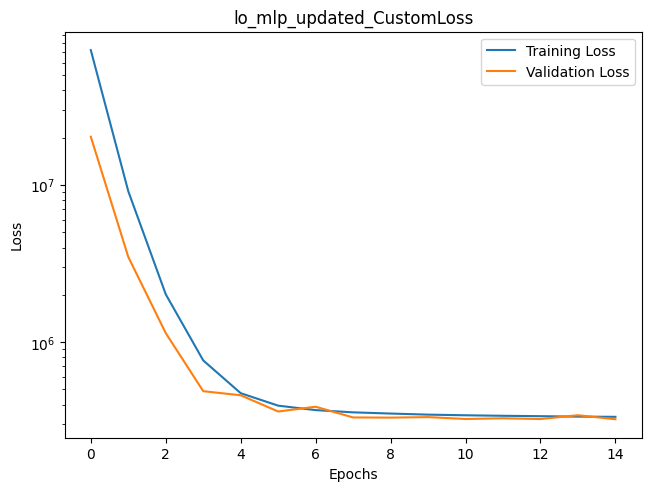

In [15]:
def plot_metrics(history: k.callbacks.History, network_name: str, save_directory: str) -> None:
    # Plot training and validation loss
    plt.figure(constrained_layout=True)
    plt.plot(history.history["loss"], label="Training Loss")
    if "val_loss" in history.history.keys():
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.yscale("log" if min(np.min(history.history["loss"]), np.min(history.history["val_loss"])) > 0.0 else "linear")
    else:
        plt.yscale("log" if np.min(history.history["loss"]) > 0.0 else "linear")
    plt.title(network_name)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig(f"{save_directory}/{network_name}_loss.png")

# Model training history
plot_metrics(history=history, network_name=EXPERIMENT_NAME, save_directory=PLOT_SAVE_DIR)


In [ ]:
# # Custom Save Function
# def save_tf_model(model, const_values, path):
#     # Save model in SavedModel format
#     model.save(path, save_format='tf')
    
#     # Save const_values dictionary
#     with open(f'{path}/diff_corss_section_ratio_dic.json', 'w') as f:
#         # Convert float keys to strings for JSON
#         const_values_str = {str(k): float(v) for k, v in const_values.items()}
#         json.dump(const_values_str, f)

# save_tf_model(model, diff_corss_section_ratio_dic, MODEL_SAVE_DIRECTORY)

# After this point, it is just for debugging purposes

In [17]:
# To get sorted list of cHW values and their corresponding weights
reverse_diff_csr_dic = {v: k for k, v in diff_corss_section_ratio_dic.items()}
sorted_dic = dict(sorted(reverse_diff_csr_dic.items()))

the_cHW_values = np.array(list(sorted_dic.keys()))
the_weights = np.array(list(sorted_dic.values()))*0.00112598 # SM weight = 0.00112598
THE_CONST_VAL = 1_000_000 # I put it as a variable, and make changes arbitrarily for debugging purposes
sum_of_the_weights = the_weights*THE_CONST_VAL 

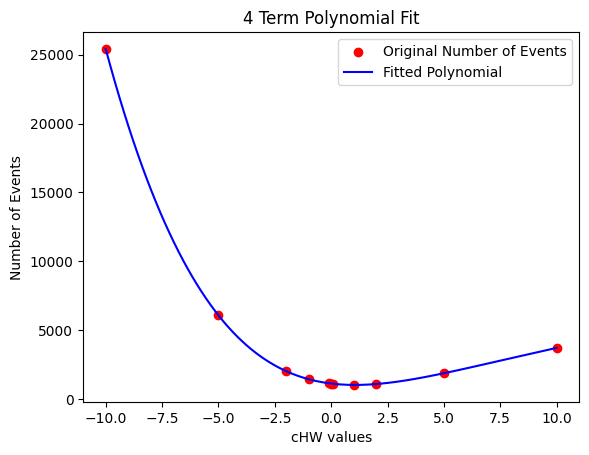

In [19]:
# Number of events with respect to cHW values
NUM_OF_POLY_TERMS = 4
cHW_polyfit_coefs = npp.polyfit(the_cHW_values, sum_of_the_weights, NUM_OF_POLY_TERMS)
x_plot = np.linspace(min(the_cHW_values), max(the_cHW_values), 100)
y_plot = npp.polyval(x_plot, cHW_polyfit_coefs)
plt.scatter(the_cHW_values, sum_of_the_weights, color='red', label='Original Number of Events')
plt.plot(x_plot, y_plot, color='blue', label='Fitted Polynomial')
plt.xlabel('cHW values')
plt.ylabel('Number of Events')
plt.legend()
plt.title(f'{NUM_OF_POLY_TERMS} Term Polynomial Fit')
# plt.savefig(f"{PLOT_SAVE_DIR}/lo_polyfit.png")
plt.show()

In [21]:
# Cutoff value for Neyman-Pearson lemma

P_VALUE = 0.95
XLABEL = r"$c_\mathrm{HW}$ Value"
EXTRA_PLOT_WIDTH = 0.01#0.003
PLOT_SHRINK = 1.0
cutoff = spsd.chi2.ppf(P_VALUE, df=1)
print(f"cutoff value is {cutoff}")

cutoff value is 3.8414588206941205


In [23]:
# Helper functions for debugging purposes.
def total_num_estimate(coefficient: npt.ArrayLike) -> np.ndarray:
        return npp.polyval(coefficient, cHW_polyfit_coefs)

def ratio_estimate(predictions: npt.ArrayLike, coefficient: float) -> np.ndarray:
    return (1.0 + coefficient * predictions[..., 0]) ** 2.0 + (coefficient * predictions[..., 1]) ** 2.0

def get_diff_crs_sec_ratio_part(predictions=None, coefficient=None):
    return np.sum(np.log(ratio_estimate(predictions=predictions, coefficient=coefficient)))

def get_total_num_diff(coefficient=None):
    return total_num_estimate(coefficient=coefficient) - total_num_estimate(coefficient=0.0)

6254/6254 [==============================] - 2s 360us/step
For cHW coefficient -1.0, total_num_estimate is 1441.8579846189505
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :315.47854400288884
The log diff cross section ratio sum is :42860.59765625


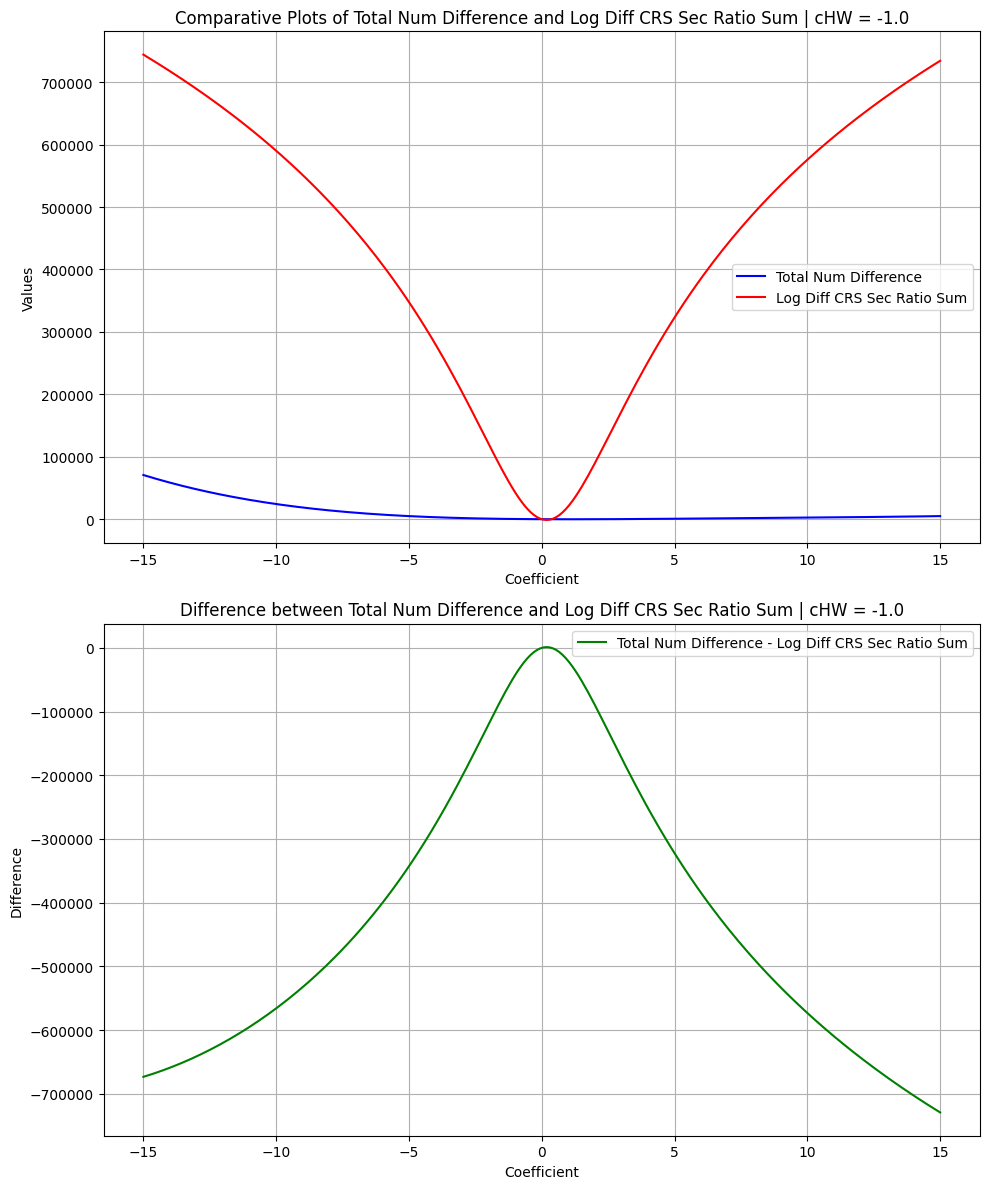

6232/6232 [==============================] - 2s 358us/step
For cHW coefficient -5.0, total_num_estimate is 6080.8020713655105
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :4954.422630749449
The log diff cross section ratio sum is :349747.03125


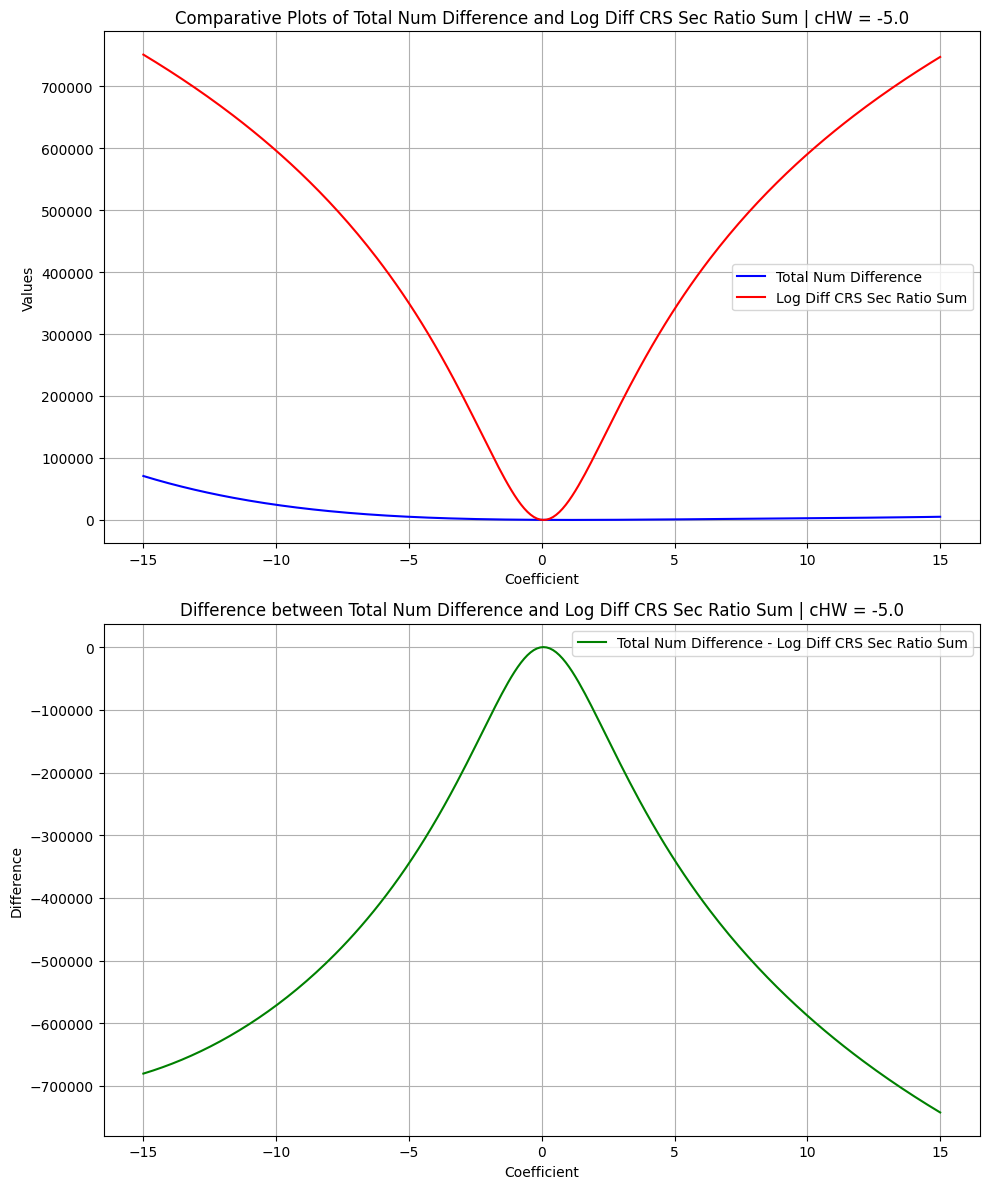

6259/6259 [==============================] - 2s 370us/step
For cHW coefficient -2.0, total_num_estimate is 2028.814914927717
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :902.4354743116553
The log diff cross section ratio sum is :119506.265625


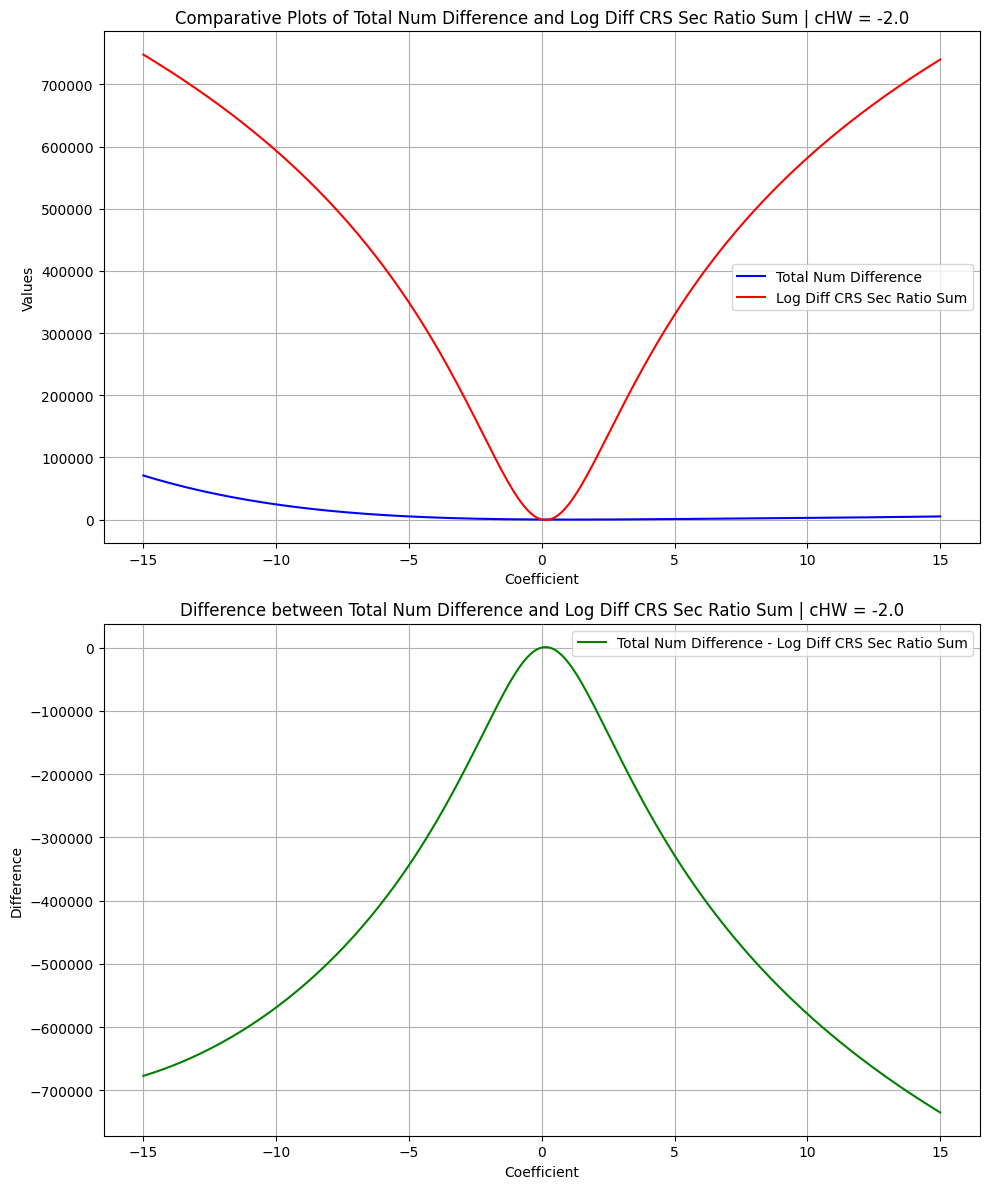

6272/6272 [==============================] - 2s 364us/step
For cHW coefficient -0.1, total_num_estimate is 1147.3704321680018
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :20.99099155194017
The log diff cross section ratio sum is :1792.5506591796875


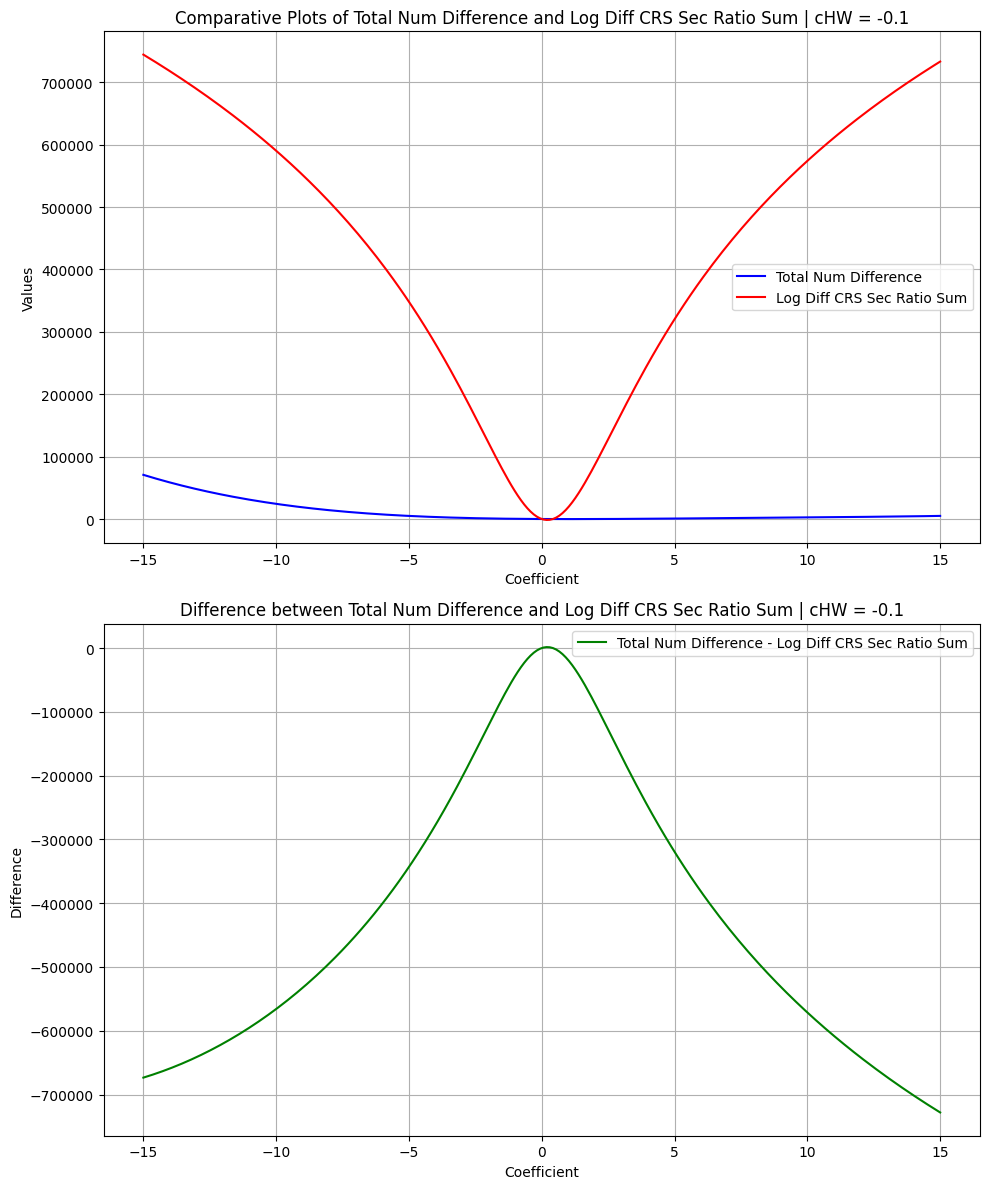

24997/24997 [==============================] - 9s 355us/step
For cHW coefficient -1.0, total_num_estimate is 1441.8579846189505
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :315.47854400288884
The log diff cross section ratio sum is :171341.0


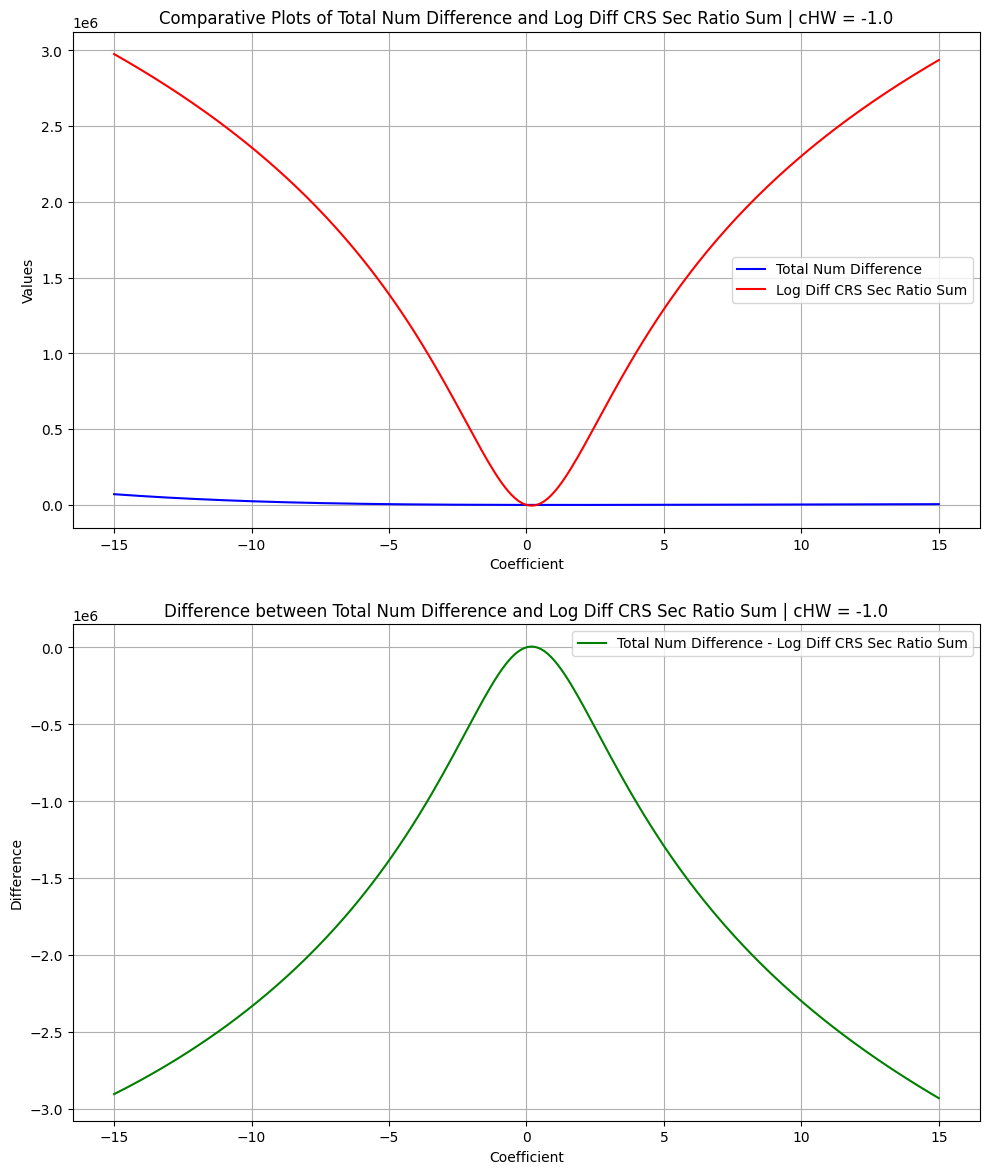

6232/6232 [==============================] - 2s 355us/step
For cHW coefficient -10.0, total_num_estimate is 25423.105418528165
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :24296.7259779121
The log diff cross section ratio sum is :598649.0625


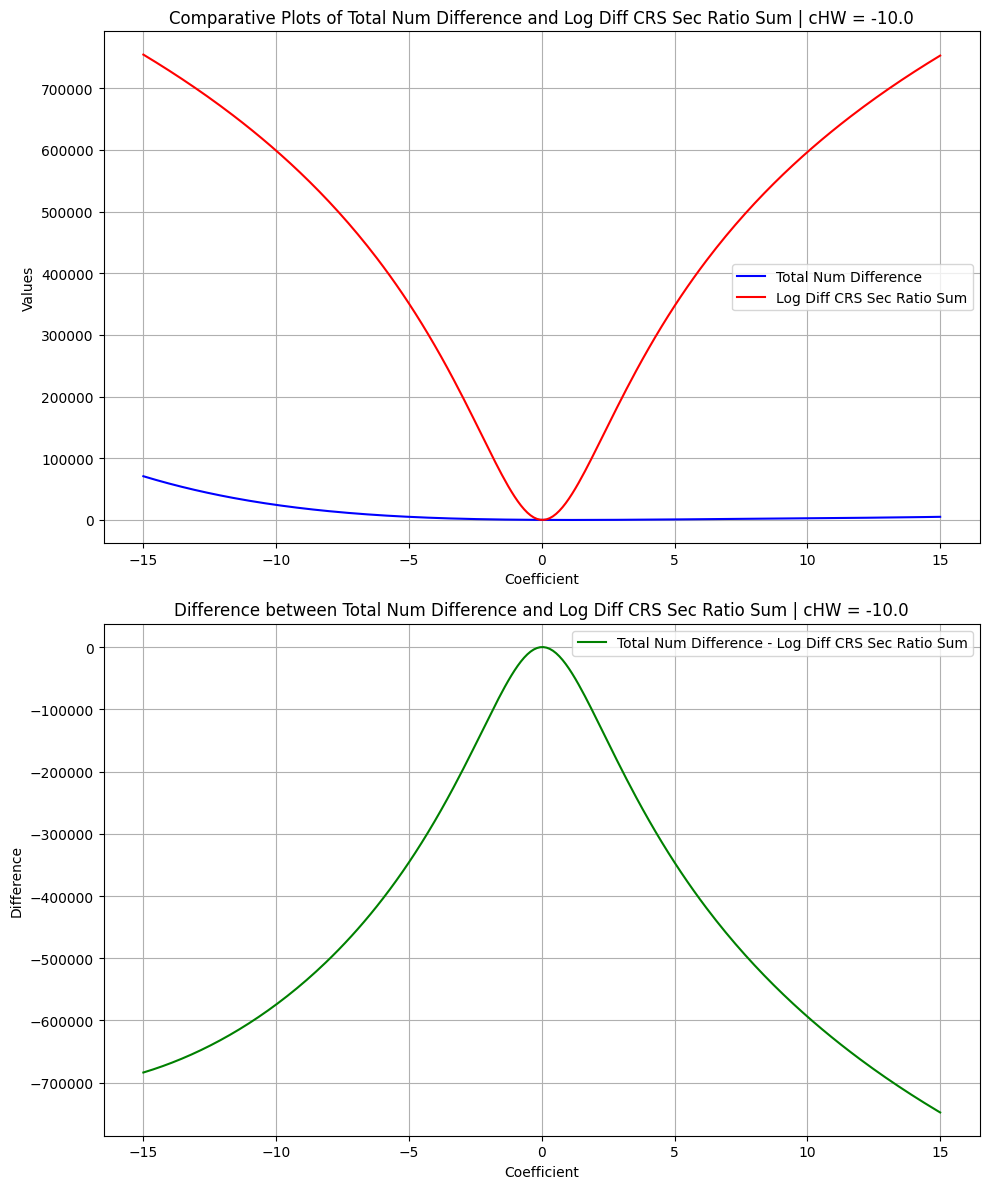

25019/25019 [==============================] - 9s 361us/step
For cHW coefficient -5.0, total_num_estimate is 6080.8020713655105
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :4954.422630749449
The log diff cross section ratio sum is :1404042.0


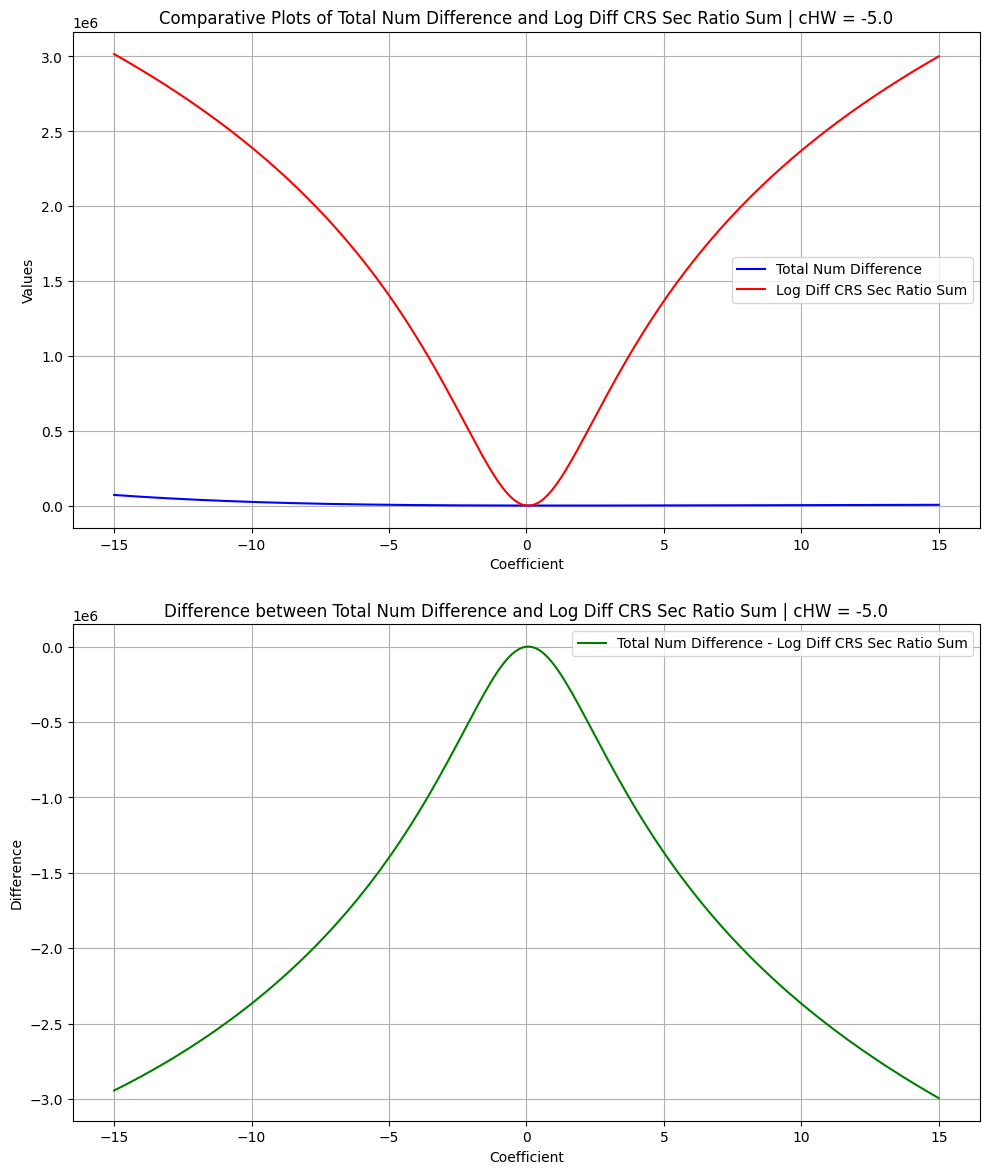

25019/25019 [==============================] - 9s 360us/step
For cHW coefficient -10.0, total_num_estimate is 25423.105418528165
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :24296.7259779121
The log diff cross section ratio sum is :2403749.25


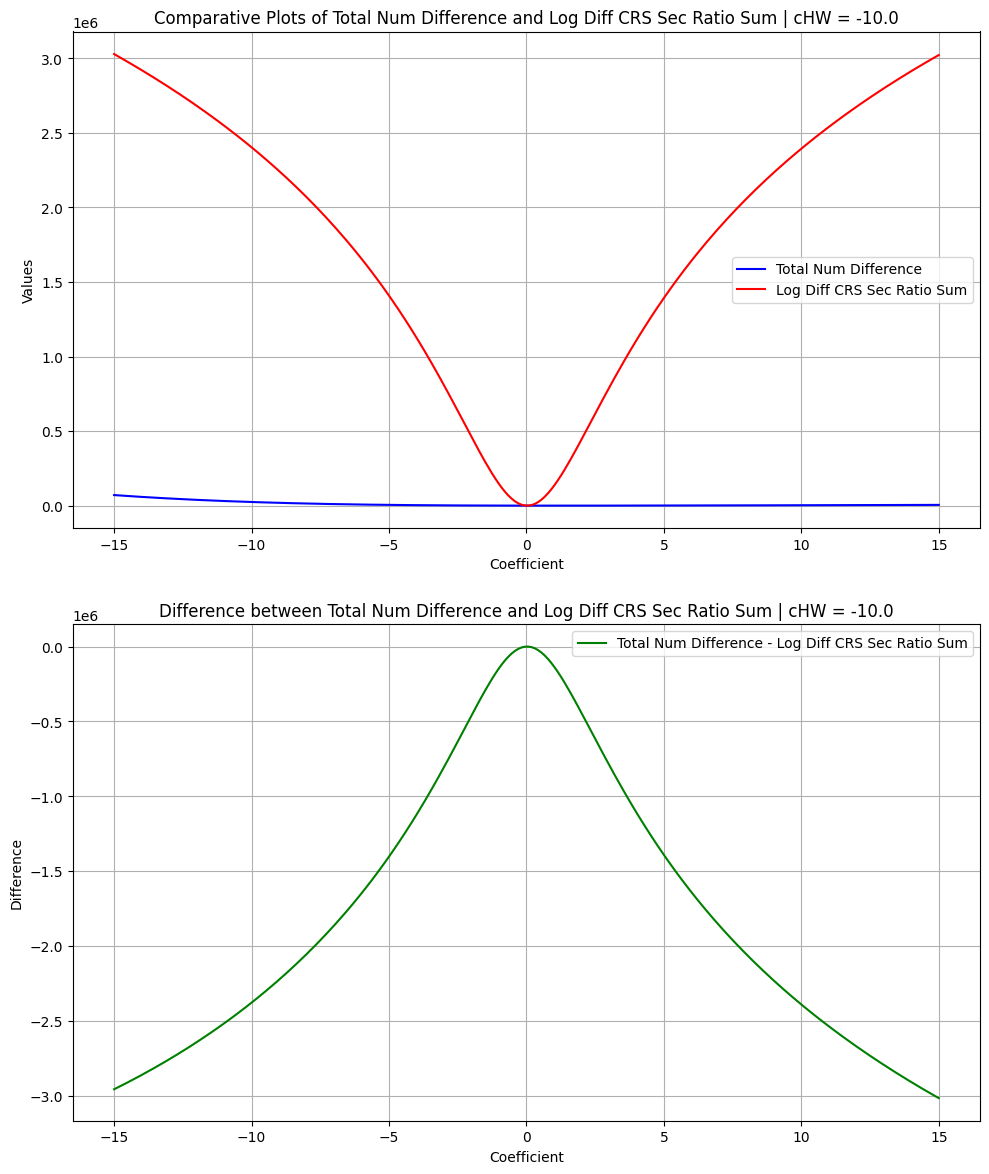

24979/24979 [==============================] - 9s 355us/step
For cHW coefficient -0.1, total_num_estimate is 1147.3704321680018
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :20.99099155194017
The log diff cross section ratio sum is :7139.4736328125


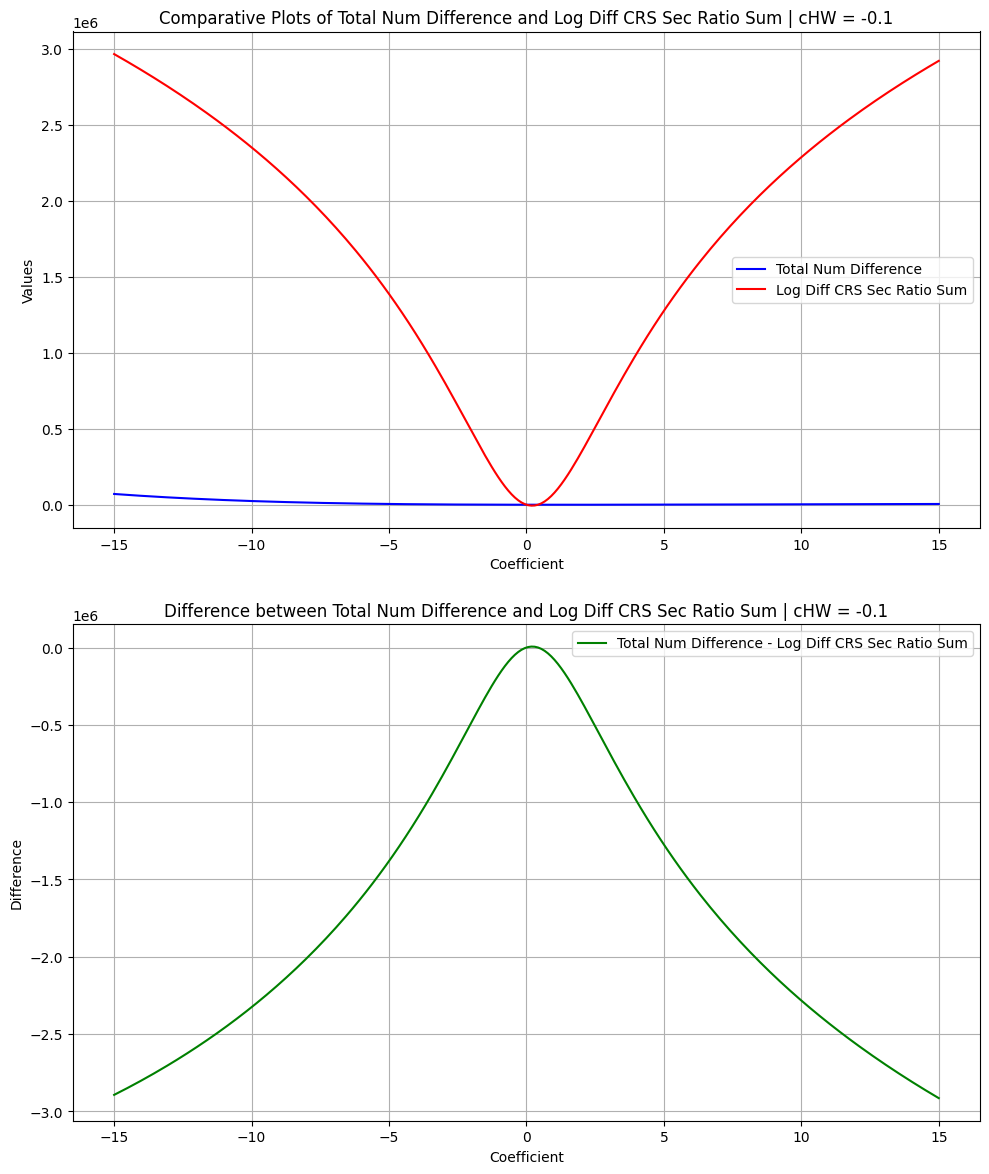

24992/24992 [==============================] - 9s 361us/step
For cHW coefficient -2.0, total_num_estimate is 2028.814914927717
For cHW coefficient 0.0, total_num_estimate is 1126.3794406160616
The difference is :902.4354743116553
The log diff cross section ratio sum is :477194.15625


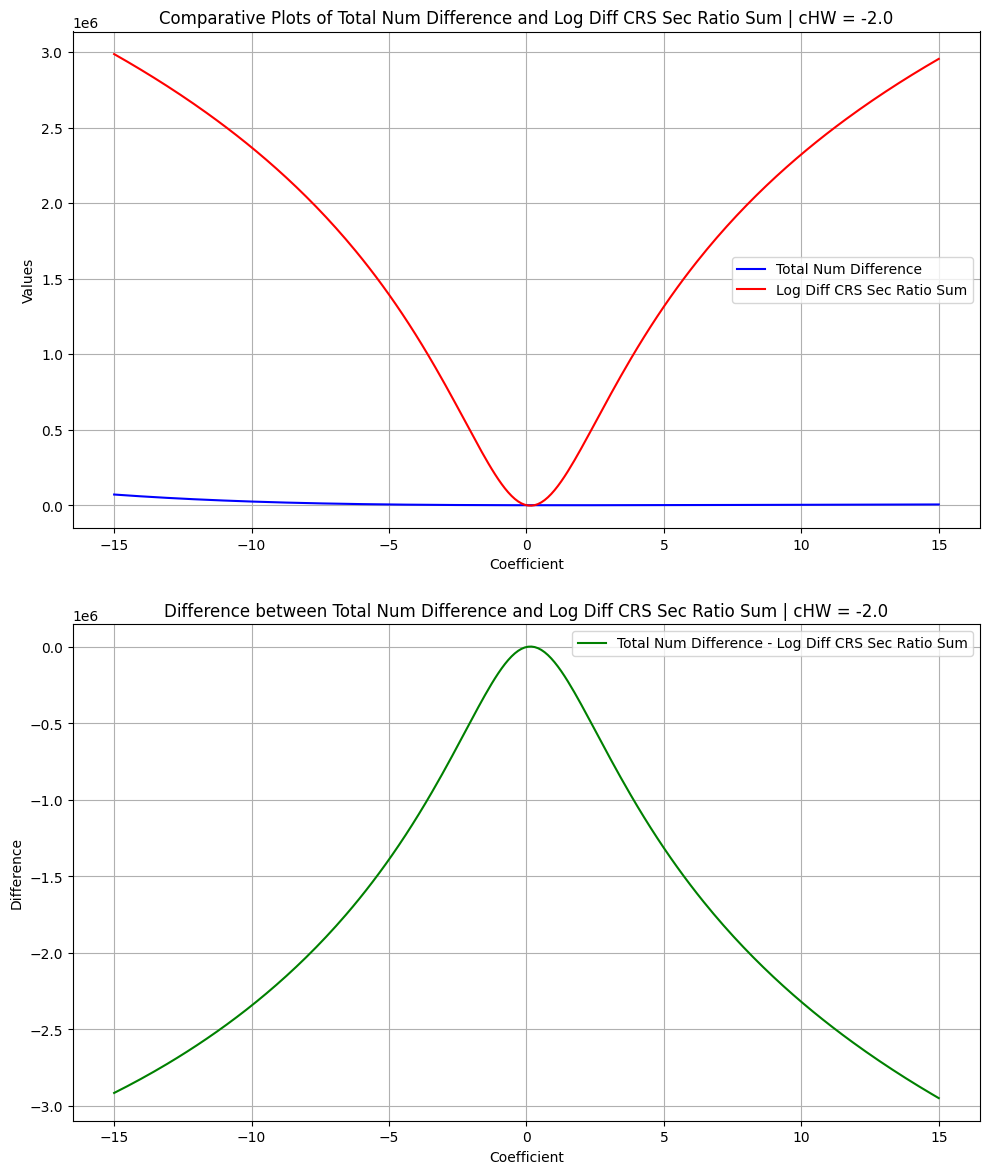

In [24]:
# Plots for debugging purposes, log(likelihood) = total_num_differences - log_diff_crs_sec_ratio_sums
#                                                      blue                         red

LO_TEST_PATHS = find_files(search_dir=SEARCH_DIR, file_name_to_be_searched="*.npy")
iter_coef_values = [float(test_path.split("_")[-1][:-4]) for test_path in LO_TEST_PATHS]

for i, lo_test_path in enumerate(LO_TEST_PATHS):
    
    lo_cHW_kinematics = np.load(lo_test_path)

    predictions = model.predict(lo_cHW_kinematics)

    debug_coefficient = iter_coef_values[i] # or some other value

    total_num_difference  = get_total_num_diff(coefficient=debug_coefficient)
    log_diff_crs_sec_ratio_sum = get_diff_crs_sec_ratio_part(predictions=predictions, coefficient=debug_coefficient)

    print(f'For cHW coefficient {debug_coefficient}, total_num_estimate is {total_num_estimate(coefficient=debug_coefficient)}')
    print(f'For cHW coefficient {0.0}, total_num_estimate is {total_num_estimate(coefficient=0.0)}')
    print(f'The difference is :{total_num_difference}')
    print(f'The log diff cross section ratio sum is :{log_diff_crs_sec_ratio_sum}')
    coeffs_for_plot = np.linspace(-15, 15, 250)  # Varying debug_coefficient from 0 to 10

    total_num_differences = [get_total_num_diff(coefficient=coef) for coef in coeffs_for_plot]
    log_diff_crs_sec_ratio_sums = [get_diff_crs_sec_ratio_part(predictions=predictions, coefficient=coef) for coef in coeffs_for_plot]

    differences = np.array(total_num_differences) - np.array(log_diff_crs_sec_ratio_sums)

    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    # First subplot
    axs[0].plot(coeffs_for_plot, total_num_differences, label='Total Num Difference', color='blue')
    axs[0].plot(coeffs_for_plot, log_diff_crs_sec_ratio_sums, label='Log Diff CRS Sec Ratio Sum', color='red')
    axs[0].set_xlabel('Coefficient')
    axs[0].set_ylabel('Values')
    axs[0].set_title(f'Comparative Plots of Total Num Difference and Log Diff CRS Sec Ratio Sum | cHW = {iter_coef_values[i]}')
    axs[0].legend()
    axs[0].grid(True)
    # Second subplot
    axs[1].plot(coeffs_for_plot, differences, label='Total Num Difference - Log Diff CRS Sec Ratio Sum', color='green')
    axs[1].set_xlabel('Coefficient')
    axs[1].set_ylabel('Difference')
    axs[1].set_title(f'Difference between Total Num Difference and Log Diff CRS Sec Ratio Sum | cHW = {iter_coef_values[i]}')
    axs[1].legend()
    axs[1].grid(True)
    plt.tight_layout()
    # plt.savefig(f'{PLOT_SAVE_DIR}/cHW_{iter_coef_values[i]}_plot.png')
    plt.show()

    del predictions, lo_cHW_kinematics
    del total_num_differences, log_diff_crs_sec_ratio_sums, differences
    del log_diff_crs_sec_ratio_sum
